In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install -q bitsandbytes datasets accelerate loralib
!pip install transformers==4.45.2
!pip install peft
!pip install matplotlib
!pip install tensorboard

In [1]:
# -------------------Set model properties-----------------------------------
model_name_or_path = "openai/whisper-small"
language = "bengali"
task = "transcribe"

In [2]:

#---------------------------Load Dataset--------------------------------------
from datasets import load_dataset, DatasetDict
# Load the full dataset
full_train = load_dataset("imonghose/bengali-asr-data", split="train", cache_dir="D:/hf_cache")
# full_test = load_dataset(
#     "imonghose/bengali-asr-data",
#     data_files={"test": ["data/test-00000-of-00002.parquet", "data/test-00001-of-00002.parquet"]},
#     split="test"
# )
full_test = load_dataset("imonghose/bengali-asr-data", split="test", cache_dir="D:/hf_cache")



# Get dataset sizes
train_size = len(full_train)
test_size = len(full_test)
# Compute the original train-test ratio
original_ratio = test_size / train_size
# Compute the new test size corresponding to 60% train size
new_train_size = int(0.05 * train_size)
new_test_size = int(0.2 * test_size)
train_sample = full_train.shuffle(seed=42).select(range(new_train_size))
test_sample = full_test.shuffle(seed=42).select(range(new_test_size))
# Create a new dataset dictionary
bangla_dataset = DatasetDict({
    "train": train_sample,
    "test": test_sample
})

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/36 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

In [2]:
#-----------Check dataset shape----------
bangla_dataset.shape

{'train': (7978, 3), 'test': (2042, 3)}

In [3]:
#-----------Check dataset structure----------
bangla_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 7978
    })
    test: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 2042
    })
})

In [ ]:
#------------------------CODE TO DELETE Loaded dataset from cache-------------------------

# !ls -lh ~/.cache/huggingface/datasets

# !rm -rf ~/.cache/huggingface/datasets/rootflo___bengali-asr-data
# !rm -rf ~/.cache/huggingface/datasets/_root_.cache_huggingface_datasets_rootflo___bengali-asr-data_default_0.0.0_bbea669d7678c71e778d0c20f4fbed55ea9bc0f7.lock

# !rm -rf ~/.cache/huggingface/
# !rm -rf ~/.cache/datasets/
# !rm -rf ~/.cache/torch/
# !rm -rf ~/.cache/

ls: cannot access '/root/.cache/huggingface/datasets': No such file or directory


In [6]:
#--------------Install correct version of Transformers library-----------------------
!pip install transformers==4.45.2
# !pip install --upgrade transformers



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path,language=language,task=task)

In [4]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path,language=language,task=task)

In [5]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [6]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [10]:
#-------------------Check sampling rate before downsampling-----------------
print(bangla_dataset["train"][16])

{'audio': {'path': None, 'array': array([-0.00280762, -0.00262451, -0.00244141, ..., -0.00317383,
        0.00238037,  0.00650024], shape=(40000,)), 'sampling_rate': 16000}, 'sentence': 'পদ্মা সেতু প্রকল্প পরিচালক', 'length': 2.5}


In [7]:
#--------------------Downsample to 16 KHz--------------------------
from datasets import Audio

bangla_dataset = bangla_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [11]:
#-------------------Check sampling rate after downsampling-----------------
print(bangla_dataset["train"][0])

{'audio': {'path': None, 'array': array([ 0.00189209,  0.0015564 ,  0.00189209, ...,  0.00039673,
        0.00033569, -0.00079346]), 'sampling_rate': 16000}, 'sentence': 'আবদুর রহমান বয়াতি', 'length': 3.2}


In [8]:
#------------------Custom preprocessing function for dataset-----------------------------
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


In [9]:
#-------------------------Execute preprocessing---------------------------
bangla_dataset = bangla_dataset.map(prepare_dataset, remove_columns=bangla_dataset.column_names["train"], num_proc=1)


In [14]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["test"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 4085
})

In [15]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["train"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 14361
})

In [ ]:
#-----------------------Check path where hugging face datasets are stored in cache--------------------
# from datasets import config
# config.HF_DATASETS_CACHE

WindowsPath('C:/Users/imong/.cache/huggingface/datasets')

In [16]:
#-------------------Check first sentence by decoding-----------------------
first_label_ids = bangla_dataset["train"][0]["labels"]  # Get the first label (token IDs)
first_sentence = tokenizer.decode(first_label_ids)  # Decode to text

print(first_sentence)


<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>আবদুর রহমান বয়াতি<|endoftext|>


In [ ]:
# -----------------------------Visualization of sentence token sizes vs frequency------------------------
import matplotlib.pyplot as plt

list_of_transcription_lengths = []

# Extract labels from dataset and compute their lengths
for data in bangla_dataset["train"]:
    list_of_transcription_lengths.append(len(data["labels"]))

# Plot the histogram
plt.hist(list_of_transcription_lengths, bins=50)  # Adjust bins for better visualization
plt.xlabel("Sentence Length (Number of Tokens)")
plt.ylabel("Number of Transcripts")
plt.title("Distribution of Transcription Lengths")
plt.show()


In [14]:
#------------------------------Check true vs prediction on few sentences before fine-tuning------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------7------
True : চলতে পারিনা 
Pred :  चोलते परिना

 
-------8------
True : নিজের স্বজনের জন্য 
Pred :  निजर साजने जन्नो

 
-------9------
True : সে যুদ্ধকেই 
Pred :  शेजुद्द के इए

 


In [11]:
#-------------------------------------Define Data Collator to introduce padding-------------------------------
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [12]:
#----------------------------Load Data Collator-----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [13]:
#------------------------Define evaluation metric wer------------------------
import evaluate
wer = evaluate.load("wer")

In [14]:
#===================================Custom Evaluation Function for WER Metric with Periodic Plotting===================================
import torch
import pickle
from tqdm import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

wer = evaluate.load("wer")
SAVE_PATH = "evaluation_progress.pkl"

def save_progress(progress):
    with open(SAVE_PATH, "wb") as f:
        pickle.dump(progress, f)

def load_progress():
    try:
        with open(SAVE_PATH, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}

def plot_wer(batch_history, wer_history):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(batch_history, wer_history, marker='o', label='WER (%)')
    plt.xlabel('Batches Processed')
    plt.ylabel('WER')
    plt.title('Running WER Evaluation')
    plt.grid(True)
    plt.legend()
    # Set ticks at intervals of 25 starting from 0 to max batch
    max_batch = max(batch_history) if batch_history else 0
    plt.xticks(np.arange(0, max_batch + 1, 25))
    display(plt.gcf())
    plt.close()

def evaluation(model, resume=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_dataset = bangla_dataset["test"]
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=data_collator
    )

    model.eval()

    # Load previous progress if resuming
    progress = load_progress() if resume else {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}
    predictions, references = progress["predictions"], progress["references"]
    start_batch = progress["processed_batches"]
    wer_history = progress.get("wer_history", [])
    batch_history = progress.get("batch_history", [])

    for batch_idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
        if batch_idx < start_batch:
            continue  # Skip already processed batches

        input_features = batch["input_features"].to(device)
        labels = batch["labels"]

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='bengali', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        is_final = (batch_idx == len(test_dataloader) - 1)
        if (batch_idx + 1) % 25 == 0 or is_final:
            current_wer = wer.compute(predictions=predictions, references=references) * 100
            wer_history.append(current_wer)
            batch_history.append(batch_idx + 1)
            plot_wer(batch_history, wer_history)
            save_progress({
                "predictions": predictions,
                "references": references,
                "processed_batches": batch_idx + 1,
                "wer_history": wer_history,
                "batch_history": batch_history
            })

    return wer_history[-1] if wer_history else None


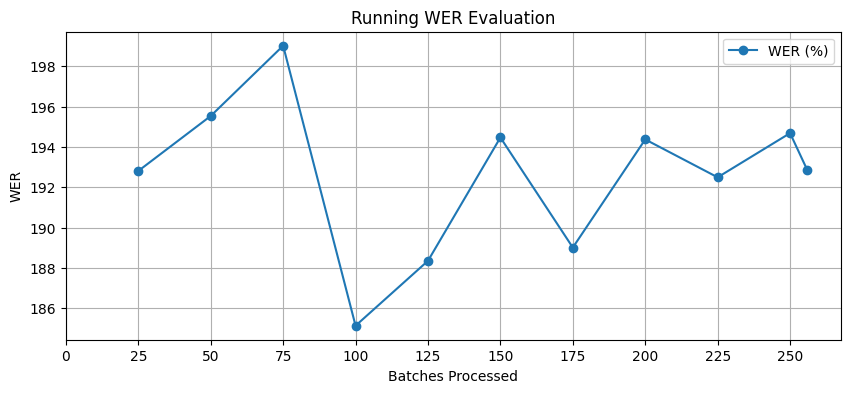

100%|██████████| 256/256 [1:23:14<00:00, 19.51s/it]


192.83608932407455

In [23]:
# Evaluate WER before the training
torch.cuda.empty_cache()
evaluation(model,resume=True)

In [24]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [35]:
from transformers import WhisperForConditionalGeneration

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Enable gradients only for bias terms
for name, param in model.named_parameters():
    if ".bias" in name:
        param.requires_grad = True


In [26]:
# Print total and trainable parameters
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total}")
print(f"Trainable Parameters (bias only): {trainable}")


Total Parameters: 241734912
Trainable Parameters (bias only): 224256


In [36]:
#----------------------------Create Training Arguments------------------------------
from transformers import Seq2SeqTrainingArguments,EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="bitfit-checkpoints",
    per_device_train_batch_size=2,  # Reduced from 8 to 2
    per_device_eval_batch_size=2,  # Reduced from 8 to 2
    gradient_accumulation_steps=2,  # Helps with small batch size
    # learning_rate=2e-5, (High)
    learning_rate=1e-5,  #(Medium)
    # learning_rate=5e-6,  #(Low)
    warmup_steps=50,
    num_train_epochs=2,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=142,
    # save_strategy="epoch",
    save_strategy="steps",
    save_steps=284, 
    save_total_limit=3,
    load_best_model_at_end=True,  # Disabling to save memory
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision enabled
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,
    label_names=["labels"],

    # Add AdamW optimizer and related arguments
    optim="adamw_torch",  # AdamW optimizer from PyTorch
    weight_decay=0.01,  # Regularization to prevent overfitting
    adam_epsilon=1e-8,   # Epsilon for numerical stability
    max_grad_norm=1.0,   # Gradient clipping
    # TensorBoard logging
    logging_dir="./bitfit-tensorboard",  # Directory for TensorBoard logs
    report_to="tensorboard",  # Enables logging to TensorBoard
)

In [37]:
#--------------------------------Create Trainer--------------------------------------
from transformers import Seq2SeqTrainer

# Use only 10% of the test dataset for evaluation
# eval_sample = bangla_dataset["test"].shuffle(seed=42).select(range(int(0.5 * len(bangla_dataset["test"]))))

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=bangla_dataset["train"],
    eval_dataset=bangla_dataset["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
model.gradient_checkpointing_enable() #Gradient checkpointing helps save memory by recomputing activations during the backward pass.

In [71]:
#-------------------Code for Cleaning GPU Cache--------------------------
# import torch
# import gc

# gc.collect()  # Clean up RAM
# torch.cuda.empty_cache()  # Free GPU memory

# print("✅ GPU memory forcibly cleared!")


✅ GPU memory forcibly cleared!


In [53]:
#----------------Code to check stored huggingface dataset files in cache---------------
# !ls -lh ~/.cache/huggingface/datasets

total 4.0K
drwxr-xr-x 3 root root 4.0K Mar 17 21:31 imonghose___bengali-asr-data
-rw-r--r-- 1 root root    0 Mar 17 21:36 _root_.cache_huggingface_datasets_imonghose___bengali-asr-data_default_0.0.0_3a297ddede51b3012d3a6eb39e9dbea12b8ccc40.lock


In [23]:
#--------------------Login to Huggingface (if required)-----------------------------------
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#-------------------Check if a checkpoint file exists-----------------------
# ls -lh checkpoints/checkpoint-1197
# checkpoint_path = get_last_checkpoint("checkpoints")
# checkpoint_path

In [38]:
#-------------------------------Start Training with support for checkpointing--------------------------
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, Trainer
from transformers.trainer_utils import get_last_checkpoint
from transformers import WhisperForConditionalGeneration


checkpoint_path = get_last_checkpoint("bitfit-checkpoints")

if checkpoint_path is not None:
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    model = WhisperForConditionalGeneration.from_pretrained(
        checkpoint_path)
    trainer.model = model  # Load the trained model into the trainer
    trainer.train(resume_from_checkpoint=checkpoint_path)  # Resume training
else:
    print("No checkpoint found, starting from scratch.")
    torch.cuda.empty_cache()
    trainer.train()  # Start training from scratch

No checkpoint found, starting from scratch.


  1%|          | 30/3988 [06:14<13:43:03, 12.48s/it]
                                                   

  1%|          | 25/3988 [00:35<1:42:03,  1.55s/it]


{'loss': 3.2167, 'grad_norm': 4.879061698913574, 'learning_rate': 5e-06, 'epoch': 0.01}


                                                   

  1%|▏         | 50/3988 [01:13<1:39:36,  1.52s/it]


{'loss': 3.0882, 'grad_norm': 4.55396842956543, 'learning_rate': 1e-05, 'epoch': 0.03}


                                                   

  2%|▏         | 75/3988 [01:51<1:28:35,  1.36s/it]


{'loss': 2.9787, 'grad_norm': 2.1939008235931396, 'learning_rate': 9.936515997968513e-06, 'epoch': 0.04}


                                                    

  3%|▎         | 100/3988 [02:24<1:24:39,  1.31s/it]


{'loss': 2.858, 'grad_norm': 2.6544430255889893, 'learning_rate': 9.873031995937025e-06, 'epoch': 0.05}


                                                    

  3%|▎         | 125/3988 [03:01<1:44:06,  1.62s/it]


{'loss': 2.891, 'grad_norm': 2.609764575958252, 'learning_rate': 9.809547993905536e-06, 'epoch': 0.06}


  4%|▎         | 142/3988 [03:28<1:41:39,  1.59s/it]
                                                    

  4%|▎         | 142/3988 [11:00<1:41:39,  1.59s/it]


{'eval_loss': 2.051696300506592, 'eval_runtime': 451.4603, 'eval_samples_per_second': 4.523, 'eval_steps_per_second': 2.262, 'epoch': 0.07}


                                                       

  4%|▍         | 150/3988 [11:13<13:40:16, 12.82s/it]


{'loss': 2.786, 'grad_norm': 2.6338422298431396, 'learning_rate': 9.748603351955308e-06, 'epoch': 0.08}


                                                     

  4%|▍         | 175/3988 [11:52<1:41:32,  1.60s/it]


{'loss': 2.7389, 'grad_norm': 2.115583658218384, 'learning_rate': 9.68511934992382e-06, 'epoch': 0.09}


                                                    

  5%|▌         | 200/3988 [12:32<1:39:34,  1.58s/it]


{'loss': 2.7957, 'grad_norm': 1.9561649560928345, 'learning_rate': 9.621635347892332e-06, 'epoch': 0.1}


                                                    

  6%|▌         | 225/3988 [13:12<1:41:05,  1.61s/it]


{'loss': 2.6572, 'grad_norm': 2.187382459640503, 'learning_rate': 9.558151345860844e-06, 'epoch': 0.11}


                                                    

  6%|▋         | 250/3988 [13:51<1:37:40,  1.57s/it]


{'loss': 2.5716, 'grad_norm': 2.460742950439453, 'learning_rate': 9.494667343829356e-06, 'epoch': 0.13}


                                                    

  7%|▋         | 275/3988 [14:31<1:35:50,  1.55s/it]


{'loss': 2.4808, 'grad_norm': 2.155947208404541, 'learning_rate': 9.431183341797868e-06, 'epoch': 0.14}


  7%|▋         | 284/3988 [14:45<1:35:20,  1.54s/it]
                                                    

  7%|▋         | 284/3988 [21:36<1:35:20,  1.54s/it]
d:\Germany\Documents\Magdeburg\Semester Documents\Sem 2\HC-NLP\Fine Tuning LLM(Bengali)\whisper-env\Lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'eval_loss': 1.958522915840149, 'eval_runtime': 411.5615, 'eval_samples_per_second': 4.962, 'eval_steps_per_second': 2.481, 'epoch': 0.14}


                                                       

  8%|▊         | 300/3988 [22:04<2:14:16,  2.18s/it]


{'loss': 2.5345, 'grad_norm': 2.3499948978424072, 'learning_rate': 9.36769933976638e-06, 'epoch': 0.15}


                                                    

  8%|▊         | 325/3988 [22:40<1:33:25,  1.53s/it]


{'loss': 2.5686, 'grad_norm': 1.8153549432754517, 'learning_rate': 9.304215337734892e-06, 'epoch': 0.16}


                                                    

  9%|▉         | 350/3988 [23:20<1:34:30,  1.56s/it]


{'loss': 2.5116, 'grad_norm': 2.224932909011841, 'learning_rate': 9.240731335703403e-06, 'epoch': 0.18}


                                                    

  9%|▉         | 375/3988 [23:59<1:34:23,  1.57s/it]


{'loss': 2.4378, 'grad_norm': 1.369885802268982, 'learning_rate': 9.177247333671915e-06, 'epoch': 0.19}


                                                    

 10%|█         | 400/3988 [24:36<1:18:51,  1.32s/it]


{'loss': 2.4359, 'grad_norm': 1.6205164194107056, 'learning_rate': 9.113763331640427e-06, 'epoch': 0.2}


                                                    

 11%|█         | 425/3988 [25:10<1:33:34,  1.58s/it]


{'loss': 2.4239, 'grad_norm': 2.0889170169830322, 'learning_rate': 9.050279329608939e-06, 'epoch': 0.21}


 11%|█         | 426/3988 [25:11<1:28:45,  1.50s/it]
                                                    

 11%|█         | 426/3988 [31:04<1:28:45,  1.50s/it]


{'eval_loss': 1.897879958152771, 'eval_runtime': 352.2456, 'eval_samples_per_second': 5.797, 'eval_steps_per_second': 2.899, 'epoch': 0.21}


                                                       

 11%|█▏        | 450/3988 [31:42<1:35:32,  1.62s/it]


{'loss': 2.3605, 'grad_norm': 1.6076908111572266, 'learning_rate': 8.986795327577451e-06, 'epoch': 0.23}


                                                    

 12%|█▏        | 475/3988 [32:16<1:16:12,  1.30s/it]


{'loss': 2.3591, 'grad_norm': 1.4443418979644775, 'learning_rate': 8.925850685627223e-06, 'epoch': 0.24}


                                                    

 13%|█▎        | 500/3988 [32:49<1:15:30,  1.30s/it]


{'loss': 2.3828, 'grad_norm': 2.1875500679016113, 'learning_rate': 8.862366683595735e-06, 'epoch': 0.25}


                                                    

 13%|█▎        | 525/3988 [33:22<1:15:58,  1.32s/it]


{'loss': 2.2779, 'grad_norm': 1.512210726737976, 'learning_rate': 8.798882681564247e-06, 'epoch': 0.26}


                                                    

 14%|█▍        | 550/3988 [33:54<1:15:11,  1.31s/it]


{'loss': 2.2451, 'grad_norm': 1.613935112953186, 'learning_rate': 8.735398679532759e-06, 'epoch': 0.28}


 14%|█▍        | 568/3988 [34:18<1:14:21,  1.30s/it]
                                                    

 14%|█▍        | 568/3988 [39:38<1:14:21,  1.30s/it]


{'eval_loss': 1.8532055616378784, 'eval_runtime': 320.597, 'eval_samples_per_second': 6.369, 'eval_steps_per_second': 3.185, 'epoch': 0.28}


                                                     

 14%|█▍        | 575/3988 [39:49<12:02:00, 12.69s/it]


{'loss': 2.2518, 'grad_norm': 1.5449228286743164, 'learning_rate': 8.67191467750127e-06, 'epoch': 0.29}


                                                     

 15%|█▌        | 600/3988 [40:22<1:14:09,  1.31s/it]


{'loss': 2.2193, 'grad_norm': 1.3568801879882812, 'learning_rate': 8.610970035551042e-06, 'epoch': 0.3}


                                                    

 16%|█▌        | 625/3988 [40:54<1:13:16,  1.31s/it]


{'loss': 2.1465, 'grad_norm': 1.8404388427734375, 'learning_rate': 8.547486033519554e-06, 'epoch': 0.31}


                                                    

 16%|█▋        | 650/3988 [41:27<1:12:51,  1.31s/it]


{'loss': 2.2035, 'grad_norm': 1.7529741525650024, 'learning_rate': 8.484002031488066e-06, 'epoch': 0.33}


                                                    

 17%|█▋        | 675/3988 [42:00<1:11:54,  1.30s/it]


{'loss': 2.1875, 'grad_norm': 1.9858847856521606, 'learning_rate': 8.420518029456578e-06, 'epoch': 0.34}


                                                    

 18%|█▊        | 700/3988 [42:36<1:15:12,  1.37s/it]


{'loss': 2.1444, 'grad_norm': 1.4775665998458862, 'learning_rate': 8.35703402742509e-06, 'epoch': 0.35}


 18%|█▊        | 710/3988 [42:49<1:11:43,  1.31s/it]
                                                    

 18%|█▊        | 710/3988 [49:18<1:11:43,  1.31s/it]


{'eval_loss': 1.8181912899017334, 'eval_runtime': 388.1468, 'eval_samples_per_second': 5.261, 'eval_steps_per_second': 2.63, 'epoch': 0.36}


                                                       

 18%|█▊        | 725/3988 [49:41<2:06:24,  2.32s/it]


{'loss': 2.1373, 'grad_norm': 1.5620588064193726, 'learning_rate': 8.293550025393602e-06, 'epoch': 0.36}


                                                    

 19%|█▉        | 750/3988 [50:20<1:25:40,  1.59s/it]


{'loss': 2.0826, 'grad_norm': 2.104332685470581, 'learning_rate': 8.230066023362114e-06, 'epoch': 0.38}


                                                    

 19%|█▉        | 775/3988 [50:59<1:23:06,  1.55s/it]


{'loss': 2.1011, 'grad_norm': 1.7606894969940186, 'learning_rate': 8.166582021330626e-06, 'epoch': 0.39}


                                                    

 20%|██        | 800/3988 [51:38<1:22:24,  1.55s/it]


{'loss': 2.0787, 'grad_norm': 1.9880629777908325, 'learning_rate': 8.103098019299137e-06, 'epoch': 0.4}


                                                    

 21%|██        | 825/3988 [52:16<1:09:37,  1.32s/it]


{'loss': 2.1252, 'grad_norm': 1.884079098701477, 'learning_rate': 8.03961401726765e-06, 'epoch': 0.41}


                                                    

 21%|██▏       | 850/3988 [52:52<1:21:23,  1.56s/it]


{'loss': 2.0941, 'grad_norm': 1.8007972240447998, 'learning_rate': 7.976130015236161e-06, 'epoch': 0.43}


 21%|██▏       | 852/3988 [52:55<1:20:50,  1.55s/it]
                                                    

 21%|██▏       | 852/3988 [59:25<1:20:50,  1.55s/it]


{'eval_loss': 1.7849805355072021, 'eval_runtime': 389.8565, 'eval_samples_per_second': 5.238, 'eval_steps_per_second': 2.619, 'epoch': 0.43}


                                                       

 22%|██▏       | 875/3988 [59:57<1:10:04,  1.35s/it] 


{'loss': 2.0634, 'grad_norm': 2.670088291168213, 'learning_rate': 7.912646013204673e-06, 'epoch': 0.44}


                                                      

 23%|██▎       | 900/3988 [1:00:29<1:07:33,  1.31s/it]


{'loss': 1.9674, 'grad_norm': 1.5627360343933105, 'learning_rate': 7.849162011173185e-06, 'epoch': 0.45}


                                                      

 23%|██▎       | 925/3988 [1:01:02<1:06:41,  1.31s/it]


{'loss': 2.0067, 'grad_norm': 1.9676692485809326, 'learning_rate': 7.785678009141697e-06, 'epoch': 0.46}


                                                      

 24%|██▍       | 950/3988 [1:01:35<1:06:22,  1.31s/it]


{'loss': 1.9892, 'grad_norm': 1.954849362373352, 'learning_rate': 7.722194007110209e-06, 'epoch': 0.48}


                                                      

 24%|██▍       | 975/3988 [1:02:08<1:05:12,  1.30s/it]


{'loss': 1.9478, 'grad_norm': 1.6992210149765015, 'learning_rate': 7.65871000507872e-06, 'epoch': 0.49}


 25%|██▍       | 994/3988 [1:02:32<1:05:13,  1.31s/it]
                                                      

 25%|██▍       | 994/3988 [1:07:50<1:05:13,  1.31s/it]


{'eval_loss': 1.7543785572052002, 'eval_runtime': 317.9631, 'eval_samples_per_second': 6.422, 'eval_steps_per_second': 3.211, 'epoch': 0.5}


                                                        

 25%|██▌       | 1000/3988 [1:07:58<14:23:44, 17.34s/it]


{'loss': 1.9545, 'grad_norm': 2.6304984092712402, 'learning_rate': 7.595226003047232e-06, 'epoch': 0.5}


                                                        

 26%|██▌       | 1025/3988 [1:08:31<1:04:10,  1.30s/it]


{'loss': 1.9431, 'grad_norm': 2.0660946369171143, 'learning_rate': 7.531742001015745e-06, 'epoch': 0.51}


                                                       

 26%|██▋       | 1050/3988 [1:09:04<1:03:59,  1.31s/it]


{'loss': 1.9231, 'grad_norm': 2.0259389877319336, 'learning_rate': 7.468257998984256e-06, 'epoch': 0.53}


                                                       

 27%|██▋       | 1075/3988 [1:09:37<1:03:18,  1.30s/it]


{'loss': 1.8726, 'grad_norm': 1.6938860416412354, 'learning_rate': 7.404773996952769e-06, 'epoch': 0.54}


                                                       

 28%|██▊       | 1100/3988 [1:10:09<1:02:43,  1.30s/it]


{'loss': 1.9228, 'grad_norm': 2.5017294883728027, 'learning_rate': 7.34128999492128e-06, 'epoch': 0.55}


                                                       

 28%|██▊       | 1125/3988 [1:10:42<1:02:02,  1.30s/it]


{'loss': 1.9032, 'grad_norm': 2.5641398429870605, 'learning_rate': 7.277805992889793e-06, 'epoch': 0.56}


 28%|██▊       | 1136/3988 [1:10:56<1:01:39,  1.30s/it]
                                                       

 28%|██▊       | 1136/3988 [1:16:15<1:01:39,  1.30s/it]


{'eval_loss': 1.7358956336975098, 'eval_runtime': 318.9808, 'eval_samples_per_second': 6.402, 'eval_steps_per_second': 3.201, 'epoch': 0.57}


                                                        

 29%|██▉       | 1150/3988 [1:16:35<1:45:35,  2.23s/it]


{'loss': 1.897, 'grad_norm': 1.7217462062835693, 'learning_rate': 7.214321990858304e-06, 'epoch': 0.58}


                                                       

 29%|██▉       | 1175/3988 [1:17:08<1:00:49,  1.30s/it]


{'loss': 1.8707, 'grad_norm': 1.9546680450439453, 'learning_rate': 7.150837988826816e-06, 'epoch': 0.59}


                                                       

 30%|███       | 1200/3988 [1:17:40<1:00:24,  1.30s/it]


{'loss': 1.92, 'grad_norm': 3.303884506225586, 'learning_rate': 7.087353986795328e-06, 'epoch': 0.6}


                                                       

 31%|███       | 1225/3988 [1:18:13<1:00:04,  1.30s/it]


{'loss': 1.8288, 'grad_norm': 1.940943717956543, 'learning_rate': 7.02386998476384e-06, 'epoch': 0.61}


                                                       

 31%|███▏      | 1250/3988 [1:18:46<1:00:30,  1.33s/it]


{'loss': 1.8621, 'grad_norm': 1.9374949932098389, 'learning_rate': 6.960385982732352e-06, 'epoch': 0.63}


                                                       

 32%|███▏      | 1275/3988 [1:19:18<58:41,  1.30s/it]


{'loss': 1.8263, 'grad_norm': 2.2055368423461914, 'learning_rate': 6.896901980700864e-06, 'epoch': 0.64}


 32%|███▏      | 1278/3988 [1:19:22<58:44,  1.30s/it]
                                                     

 32%|███▏      | 1278/3988 [1:24:39<58:44,  1.30s/it]


{'eval_loss': 1.7229984998703003, 'eval_runtime': 316.6942, 'eval_samples_per_second': 6.448, 'eval_steps_per_second': 3.224, 'epoch': 0.64}


                                                        

 33%|███▎      | 1300/3988 [1:25:07<1:00:44,  1.36s/it]


{'loss': 1.8241, 'grad_norm': 1.8884327411651611, 'learning_rate': 6.833417978669376e-06, 'epoch': 0.65}


                                                       

 33%|███▎      | 1325/3988 [1:25:40<57:57,  1.31s/it]


{'loss': 1.8047, 'grad_norm': 4.6122565269470215, 'learning_rate': 6.7699339766378876e-06, 'epoch': 0.66}


                                                     

 34%|███▍      | 1350/3988 [1:26:13<57:39,  1.31s/it]


{'loss': 1.8688, 'grad_norm': 2.7229702472686768, 'learning_rate': 6.7064499746063994e-06, 'epoch': 0.68}


                                                     

 34%|███▍      | 1375/3988 [1:26:46<56:49,  1.30s/it]


{'loss': 1.8038, 'grad_norm': 1.8175287246704102, 'learning_rate': 6.642965972574912e-06, 'epoch': 0.69}


                                                     

 35%|███▌      | 1400/3988 [1:27:19<56:33,  1.31s/it]


{'loss': 1.8247, 'grad_norm': 2.414076805114746, 'learning_rate': 6.579481970543423e-06, 'epoch': 0.7}


 36%|███▌      | 1420/3988 [1:27:45<56:19,  1.32s/it]
                                                     

 36%|███▌      | 1420/3988 [1:33:13<56:19,  1.32s/it]


{'eval_loss': 1.7096363306045532, 'eval_runtime': 328.0237, 'eval_samples_per_second': 6.225, 'eval_steps_per_second': 3.113, 'epoch': 0.71}


                                                         

 36%|███▌      | 1425/3988 [1:33:22<17:53:01, 25.12s/it]


{'loss': 1.8354, 'grad_norm': 2.622545003890991, 'learning_rate': 6.515997968511936e-06, 'epoch': 0.71}


                                                        

 36%|███▋      | 1450/3988 [1:33:55<55:55,  1.32s/it]


{'loss': 1.8176, 'grad_norm': 1.415966510772705, 'learning_rate': 6.452513966480447e-06, 'epoch': 0.73}


                                                     

 37%|███▋      | 1475/3988 [1:34:28<55:22,  1.32s/it]


{'loss': 1.8408, 'grad_norm': 1.9892380237579346, 'learning_rate': 6.38902996444896e-06, 'epoch': 0.74}


                                                     

 38%|███▊      | 1500/3988 [1:35:00<54:07,  1.31s/it]


{'loss': 1.7923, 'grad_norm': 36.331077575683594, 'learning_rate': 6.325545962417471e-06, 'epoch': 0.75}


                                                     

 38%|███▊      | 1525/3988 [1:35:33<53:34,  1.31s/it]


{'loss': 1.779, 'grad_norm': 2.179414987564087, 'learning_rate': 6.262061960385983e-06, 'epoch': 0.76}


                                                     

 39%|███▉      | 1550/3988 [1:36:06<53:40,  1.32s/it]


{'loss': 1.7964, 'grad_norm': 6.0408430099487305, 'learning_rate': 6.1985779583544944e-06, 'epoch': 0.78}


 39%|███▉      | 1562/3988 [1:36:22<52:32,  1.30s/it]
                                                     

 39%|███▉      | 1562/3988 [1:41:50<52:32,  1.30s/it]


{'eval_loss': 1.7022154331207275, 'eval_runtime': 327.6142, 'eval_samples_per_second': 6.233, 'eval_steps_per_second': 3.116, 'epoch': 0.78}


                                                        

 39%|███▉      | 1575/3988 [1:42:07<1:48:11,  2.69s/it]


{'loss': 1.8323, 'grad_norm': 2.8114449977874756, 'learning_rate': 6.135093956323007e-06, 'epoch': 0.79}


                                                       

 40%|████      | 1600/3988 [1:42:40<52:13,  1.31s/it]


{'loss': 1.7656, 'grad_norm': 2.1549763679504395, 'learning_rate': 6.071609954291518e-06, 'epoch': 0.8}


                                                     

 41%|████      | 1625/3988 [1:43:13<52:04,  1.32s/it]


{'loss': 1.7727, 'grad_norm': 1.675573468208313, 'learning_rate': 6.008125952260031e-06, 'epoch': 0.81}


                                                     

 41%|████▏     | 1650/3988 [1:43:46<51:28,  1.32s/it]


{'loss': 1.7882, 'grad_norm': 1.7382919788360596, 'learning_rate': 5.944641950228543e-06, 'epoch': 0.83}


                                                     

 42%|████▏     | 1675/3988 [1:44:18<50:28,  1.31s/it]


{'loss': 1.7875, 'grad_norm': 2.353785991668701, 'learning_rate': 5.881157948197055e-06, 'epoch': 0.84}


                                                     

 43%|████▎     | 1700/3988 [1:44:51<50:35,  1.33s/it]


{'loss': 1.7667, 'grad_norm': 1.6196277141571045, 'learning_rate': 5.8176739461655665e-06, 'epoch': 0.85}


 43%|████▎     | 1704/3988 [1:44:57<50:25,  1.32s/it]
                                                     

 43%|████▎     | 1704/3988 [1:50:26<50:25,  1.32s/it]


{'eval_loss': 1.692149043083191, 'eval_runtime': 328.9035, 'eval_samples_per_second': 6.209, 'eval_steps_per_second': 3.104, 'epoch': 0.85}


                                                         

 43%|████▎     | 1725/3988 [1:50:55<52:54,  1.40s/it]


{'loss': 1.7708, 'grad_norm': 10.312712669372559, 'learning_rate': 5.754189944134078e-06, 'epoch': 0.86}


                                                     

 44%|████▍     | 1750/3988 [1:51:28<48:46,  1.31s/it]


{'loss': 1.7658, 'grad_norm': 2.0520451068878174, 'learning_rate': 5.69070594210259e-06, 'epoch': 0.88}


                                                     

 45%|████▍     | 1775/3988 [1:52:01<48:37,  1.32s/it]


{'loss': 1.7693, 'grad_norm': 1.5826644897460938, 'learning_rate': 5.627221940071103e-06, 'epoch': 0.89}


                                                     

 45%|████▌     | 1800/3988 [1:52:34<47:44,  1.31s/it]


{'loss': 1.7646, 'grad_norm': 1.763014793395996, 'learning_rate': 5.563737938039614e-06, 'epoch': 0.9}


                                                     

 46%|████▌     | 1825/3988 [1:53:07<48:16,  1.34s/it]


{'loss': 1.7604, 'grad_norm': 1.4767028093338013, 'learning_rate': 5.500253936008127e-06, 'epoch': 0.92}


 46%|████▋     | 1846/3988 [1:53:35<47:22,  1.33s/it]
                                                     

 46%|████▋     | 1846/3988 [1:59:01<47:22,  1.33s/it]


{'eval_loss': 1.6827839612960815, 'eval_runtime': 326.3739, 'eval_samples_per_second': 6.257, 'eval_steps_per_second': 3.128, 'epoch': 0.93}


                                                        

 46%|████▋     | 1850/3988 [1:59:06<20:43:43, 34.90s/it]


{'loss': 1.7831, 'grad_norm': 1.6507638692855835, 'learning_rate': 5.436769933976639e-06, 'epoch': 0.93}


                                                        

 47%|████▋     | 1875/3988 [1:59:39<46:35,  1.32s/it]


{'loss': 1.8032, 'grad_norm': 1.2377134561538696, 'learning_rate': 5.3732859319451505e-06, 'epoch': 0.94}


                                                     

 48%|████▊     | 1900/3988 [2:00:12<45:33,  1.31s/it]


{'loss': 1.7163, 'grad_norm': 2.1774466037750244, 'learning_rate': 5.309801929913662e-06, 'epoch': 0.95}


                                                     

 48%|████▊     | 1925/3988 [2:00:45<44:49,  1.30s/it]


{'loss': 1.717, 'grad_norm': 1.945839524269104, 'learning_rate': 5.246317927882174e-06, 'epoch': 0.97}


                                                     

 49%|████▉     | 1950/3988 [2:01:18<44:54,  1.32s/it]


{'loss': 1.7802, 'grad_norm': 1.7318006753921509, 'learning_rate': 5.182833925850687e-06, 'epoch': 0.98}


                                                     

 50%|████▉     | 1975/3988 [2:01:51<44:13,  1.32s/it]


{'loss': 1.7641, 'grad_norm': 1.7610504627227783, 'learning_rate': 5.119349923819198e-06, 'epoch': 0.99}


 50%|████▉     | 1988/3988 [2:02:08<43:45,  1.31s/it]
                                                     

 50%|████▉     | 1988/3988 [2:07:34<43:45,  1.31s/it]


{'eval_loss': 1.6720998287200928, 'eval_runtime': 326.7042, 'eval_samples_per_second': 6.25, 'eval_steps_per_second': 3.125, 'epoch': 1.0}


                                                        

 50%|█████     | 2000/3988 [2:07:52<1:47:00,  3.23s/it]


{'loss': 1.7283, 'grad_norm': 1.7322458028793335, 'learning_rate': 5.055865921787711e-06, 'epoch': 1.0}


                                                       

 51%|█████     | 2025/3988 [2:08:24<41:50,  1.28s/it]


{'loss': 1.7423, 'grad_norm': 1.5843068361282349, 'learning_rate': 4.992381919756222e-06, 'epoch': 1.02}


                                                     

 51%|█████▏    | 2050/3988 [2:08:56<40:51,  1.27s/it]


{'loss': 1.7127, 'grad_norm': 1.8612228631973267, 'learning_rate': 4.9288979177247336e-06, 'epoch': 1.03}


                                                     

 52%|█████▏    | 2075/3988 [2:09:28<40:33,  1.27s/it]


{'loss': 1.764, 'grad_norm': 1.9308439493179321, 'learning_rate': 4.8654139156932454e-06, 'epoch': 1.04}


                                                     

 53%|█████▎    | 2100/3988 [2:10:00<40:08,  1.28s/it]


{'loss': 1.7559, 'grad_norm': 2.190845251083374, 'learning_rate': 4.801929913661757e-06, 'epoch': 1.05}


                                                     

 53%|█████▎    | 2125/3988 [2:10:32<39:41,  1.28s/it]


{'loss': 1.7237, 'grad_norm': 1.4937998056411743, 'learning_rate': 4.738445911630269e-06, 'epoch': 1.07}


 53%|█████▎    | 2130/3988 [2:10:38<39:57,  1.29s/it]
                                                     

 53%|█████▎    | 2130/3988 [2:16:06<39:57,  1.29s/it]


{'eval_loss': 1.6675301790237427, 'eval_runtime': 327.294, 'eval_samples_per_second': 6.239, 'eval_steps_per_second': 3.12, 'epoch': 1.07}


                                                        

 54%|█████▍    | 2150/3988 [2:16:31<42:16,  1.38s/it]


{'loss': 1.7296, 'grad_norm': 1.7115581035614014, 'learning_rate': 4.674961909598781e-06, 'epoch': 1.08}


                                                     

 55%|█████▍    | 2175/3988 [2:17:03<38:22,  1.27s/it]


{'loss': 1.7036, 'grad_norm': 2.3630425930023193, 'learning_rate': 4.611477907567293e-06, 'epoch': 1.09}


                                                     

 55%|█████▌    | 2200/3988 [2:17:35<38:04,  1.28s/it]


{'loss': 1.7178, 'grad_norm': 1.6251771450042725, 'learning_rate': 4.547993905535805e-06, 'epoch': 1.1}


                                                     

 56%|█████▌    | 2225/3988 [2:18:07<37:15,  1.27s/it]


{'loss': 1.7345, 'grad_norm': 2.334628105163574, 'learning_rate': 4.4845099035043175e-06, 'epoch': 1.12}


                                                     

 56%|█████▋    | 2250/3988 [2:18:39<36:50,  1.27s/it]


{'loss': 1.7184, 'grad_norm': 2.6234278678894043, 'learning_rate': 4.421025901472829e-06, 'epoch': 1.13}


 57%|█████▋    | 2272/3988 [2:19:07<36:39,  1.28s/it]
                                                     

 57%|█████▋    | 2272/3988 [2:24:36<36:39,  1.28s/it]


{'eval_loss': 1.6598669290542603, 'eval_runtime': 328.6878, 'eval_samples_per_second': 6.213, 'eval_steps_per_second': 3.106, 'epoch': 1.14}


                                                         

 57%|█████▋    | 2275/3988 [2:24:42<23:47:02, 49.98s/it]


{'loss': 1.6743, 'grad_norm': 1.7747808694839478, 'learning_rate': 4.357541899441341e-06, 'epoch': 1.14}


                                                        

 58%|█████▊    | 2300/3988 [2:25:14<36:06,  1.28s/it]


{'loss': 1.6998, 'grad_norm': 2.2716073989868164, 'learning_rate': 4.294057897409853e-06, 'epoch': 1.15}


                                                     

 58%|█████▊    | 2325/3988 [2:25:46<35:41,  1.29s/it]


{'loss': 1.6967, 'grad_norm': 2.8498151302337646, 'learning_rate': 4.230573895378365e-06, 'epoch': 1.17}


                                                     

 59%|█████▉    | 2350/3988 [2:26:19<34:37,  1.27s/it]


{'loss': 1.7346, 'grad_norm': 1.675285816192627, 'learning_rate': 4.167089893346877e-06, 'epoch': 1.18}


                                                     

 60%|█████▉    | 2375/3988 [2:26:51<34:07,  1.27s/it]


{'loss': 1.6998, 'grad_norm': 1.930294394493103, 'learning_rate': 4.103605891315389e-06, 'epoch': 1.19}


                                                     

 60%|██████    | 2400/3988 [2:27:22<33:23,  1.26s/it]


{'loss': 1.7049, 'grad_norm': 1.901412010192871, 'learning_rate': 4.040121889283901e-06, 'epoch': 1.2}


 61%|██████    | 2414/3988 [2:27:40<33:31,  1.28s/it]
                                                     

 61%|██████    | 2414/3988 [2:33:02<33:31,  1.28s/it]


{'eval_loss': 1.6564487218856812, 'eval_runtime': 321.7494, 'eval_samples_per_second': 6.347, 'eval_steps_per_second': 3.173, 'epoch': 1.21}


                                                        

 61%|██████    | 2425/3988 [2:33:16<1:43:51,  3.99s/it]


{'loss': 1.7045, 'grad_norm': 3.7410566806793213, 'learning_rate': 3.9766378872524125e-06, 'epoch': 1.22}


                                                       

 61%|██████▏   | 2450/3988 [2:33:48<32:31,  1.27s/it]


{'loss': 1.7138, 'grad_norm': 2.419504404067993, 'learning_rate': 3.913153885220924e-06, 'epoch': 1.23}


                                                     

 62%|██████▏   | 2475/3988 [2:34:20<32:21,  1.28s/it]


{'loss': 1.7205, 'grad_norm': 4.497917175292969, 'learning_rate': 3.849669883189436e-06, 'epoch': 1.24}


                                                     

 63%|██████▎   | 2500/3988 [2:34:52<31:33,  1.27s/it]


{'loss': 1.7245, 'grad_norm': 2.4535651206970215, 'learning_rate': 3.786185881157948e-06, 'epoch': 1.25}


                                                     

 63%|██████▎   | 2525/3988 [2:35:23<30:50,  1.26s/it]


{'loss': 1.7174, 'grad_norm': 4.083356857299805, 'learning_rate': 3.72270187912646e-06, 'epoch': 1.27}


                                                     

 64%|██████▍   | 2550/3988 [2:35:55<30:26,  1.27s/it]


{'loss': 1.6929, 'grad_norm': 1.8206684589385986, 'learning_rate': 3.6592178770949723e-06, 'epoch': 1.28}


 64%|██████▍   | 2556/3988 [2:36:03<30:21,  1.27s/it]
                                                     

 64%|██████▍   | 2556/3988 [2:41:21<30:21,  1.27s/it]


{'eval_loss': 1.648643970489502, 'eval_runtime': 318.5806, 'eval_samples_per_second': 6.41, 'eval_steps_per_second': 3.205, 'epoch': 1.28}


                                                        

 65%|██████▍   | 2575/3988 [2:41:47<33:18,  1.41s/it]


{'loss': 1.6837, 'grad_norm': 2.159945249557495, 'learning_rate': 3.595733875063484e-06, 'epoch': 1.29}


                                                     

 65%|██████▌   | 2600/3988 [2:42:19<29:23,  1.27s/it]


{'loss': 1.7092, 'grad_norm': 1.7310577630996704, 'learning_rate': 3.532249873031996e-06, 'epoch': 1.3}


                                                     

 66%|██████▌   | 2625/3988 [2:42:50<29:03,  1.28s/it]


{'loss': 1.6961, 'grad_norm': 1.660774827003479, 'learning_rate': 3.468765871000508e-06, 'epoch': 1.32}


                                                     

 66%|██████▋   | 2650/3988 [2:43:22<28:05,  1.26s/it]


{'loss': 1.6834, 'grad_norm': 2.358818531036377, 'learning_rate': 3.40528186896902e-06, 'epoch': 1.33}


                                                     

 67%|██████▋   | 2675/3988 [2:43:54<27:29,  1.26s/it]


{'loss': 1.7004, 'grad_norm': 2.0548791885375977, 'learning_rate': 3.341797866937532e-06, 'epoch': 1.34}


 68%|██████▊   | 2698/3988 [2:44:23<27:19,  1.27s/it]
                                                     

 68%|██████▊   | 2698/3988 [2:49:38<27:19,  1.27s/it]


{'eval_loss': 1.646491527557373, 'eval_runtime': 315.5082, 'eval_samples_per_second': 6.472, 'eval_steps_per_second': 3.236, 'epoch': 1.35}


                                                        

 68%|██████▊   | 2700/3988 [2:49:41<24:09:38, 67.53s/it]


{'loss': 1.7082, 'grad_norm': 2.297212839126587, 'learning_rate': 3.2783138649060444e-06, 'epoch': 1.35}


                                                        

 68%|██████▊   | 2725/3988 [2:50:12<26:43,  1.27s/it]


{'loss': 1.6746, 'grad_norm': 1.6198614835739136, 'learning_rate': 3.2148298628745562e-06, 'epoch': 1.37}


                                                     

 69%|██████▉   | 2750/3988 [2:50:44<26:02,  1.26s/it]


{'loss': 1.6561, 'grad_norm': 2.2217743396759033, 'learning_rate': 3.151345860843068e-06, 'epoch': 1.38}


                                                     

 70%|██████▉   | 2775/3988 [2:51:16<25:29,  1.26s/it]


{'loss': 1.7196, 'grad_norm': 3.0847220420837402, 'learning_rate': 3.0904012188928397e-06, 'epoch': 1.39}


                                                     

 70%|███████   | 2800/3988 [2:51:47<25:13,  1.27s/it]


{'loss': 1.7056, 'grad_norm': 1.5240588188171387, 'learning_rate': 3.0269172168613516e-06, 'epoch': 1.4}


                                                     

 71%|███████   | 2825/3988 [2:52:19<24:36,  1.27s/it]


{'loss': 1.6585, 'grad_norm': 2.411875009536743, 'learning_rate': 2.9634332148298634e-06, 'epoch': 1.42}


 71%|███████   | 2840/3988 [2:52:38<24:23,  1.28s/it]
                                                     

 71%|███████   | 2840/3988 [2:57:57<24:23,  1.28s/it]


{'eval_loss': 1.6415441036224365, 'eval_runtime': 318.89, 'eval_samples_per_second': 6.403, 'eval_steps_per_second': 3.202, 'epoch': 1.42}


                                                        

 71%|███████▏  | 2850/3988 [2:58:12<1:37:48,  5.16s/it]


{'loss': 1.6589, 'grad_norm': 1.766434907913208, 'learning_rate': 2.8999492127983753e-06, 'epoch': 1.43}


                                                       

 72%|███████▏  | 2875/3988 [2:58:43<23:37,  1.27s/it]


{'loss': 1.7037, 'grad_norm': 1.7009841203689575, 'learning_rate': 2.836465210766887e-06, 'epoch': 1.44}


                                                     

 73%|███████▎  | 2900/3988 [2:59:15<22:50,  1.26s/it]


{'loss': 1.6681, 'grad_norm': 1.637430191040039, 'learning_rate': 2.772981208735399e-06, 'epoch': 1.45}


                                                     

 73%|███████▎  | 2925/3988 [2:59:47<22:33,  1.27s/it]


{'loss': 1.6709, 'grad_norm': 1.7087671756744385, 'learning_rate': 2.709497206703911e-06, 'epoch': 1.47}


                                                     

 74%|███████▍  | 2950/3988 [3:00:19<21:57,  1.27s/it]


{'loss': 1.6899, 'grad_norm': 2.155123472213745, 'learning_rate': 2.646013204672423e-06, 'epoch': 1.48}


                                                     

 75%|███████▍  | 2975/3988 [3:00:51<21:27,  1.27s/it]


{'loss': 1.6991, 'grad_norm': 1.9178916215896606, 'learning_rate': 2.5825292026409347e-06, 'epoch': 1.49}


 75%|███████▍  | 2982/3988 [3:00:59<21:21,  1.27s/it]
                                                     

 75%|███████▍  | 2982/3988 [3:06:17<21:21,  1.27s/it]


{'eval_loss': 1.6370893716812134, 'eval_runtime': 317.9899, 'eval_samples_per_second': 6.422, 'eval_steps_per_second': 3.211, 'epoch': 1.5}


                                                        

 75%|███████▌  | 3000/3988 [3:06:40<24:36,  1.49s/it]


{'loss': 1.6889, 'grad_norm': 2.2753748893737793, 'learning_rate': 2.519045200609447e-06, 'epoch': 1.5}


                                                     

 76%|███████▌  | 3025/3988 [3:07:12<20:18,  1.26s/it]


{'loss': 1.67, 'grad_norm': 1.8523973226547241, 'learning_rate': 2.4555611985779584e-06, 'epoch': 1.52}


                                                     

 76%|███████▋  | 3050/3988 [3:07:44<19:50,  1.27s/it]


{'loss': 1.6724, 'grad_norm': 2.161374807357788, 'learning_rate': 2.3920771965464703e-06, 'epoch': 1.53}


                                                     

 77%|███████▋  | 3075/3988 [3:08:16<19:30,  1.28s/it]


{'loss': 1.6719, 'grad_norm': 1.8576078414916992, 'learning_rate': 2.328593194514982e-06, 'epoch': 1.54}


                                                     

 78%|███████▊  | 3100/3988 [3:08:48<18:54,  1.28s/it]


{'loss': 1.6409, 'grad_norm': 2.1231889724731445, 'learning_rate': 2.2651091924834945e-06, 'epoch': 1.55}


 78%|███████▊  | 3124/3988 [3:09:18<18:11,  1.26s/it]
                                                     

 78%|███████▊  | 3124/3988 [3:14:33<18:11,  1.26s/it]


{'eval_loss': 1.6334660053253174, 'eval_runtime': 314.8268, 'eval_samples_per_second': 6.486, 'eval_steps_per_second': 3.243, 'epoch': 1.57}


                                                        

 78%|███████▊  | 3125/3988 [3:14:36<23:05:07, 96.30s/it]


{'loss': 1.6762, 'grad_norm': 2.097083806991577, 'learning_rate': 2.2016251904520063e-06, 'epoch': 1.57}


                                                        

 79%|███████▉  | 3150/3988 [3:15:08<17:56,  1.28s/it]


{'loss': 1.6694, 'grad_norm': 1.695595383644104, 'learning_rate': 2.1381411884205182e-06, 'epoch': 1.58}


                                                     

 80%|███████▉  | 3175/3988 [3:15:40<17:31,  1.29s/it]


{'loss': 1.6422, 'grad_norm': 1.9640048742294312, 'learning_rate': 2.07465718638903e-06, 'epoch': 1.59}


                                                     

 80%|████████  | 3200/3988 [3:16:12<16:59,  1.29s/it]


{'loss': 1.6808, 'grad_norm': 1.4148015975952148, 'learning_rate': 2.011173184357542e-06, 'epoch': 1.6}


                                                     

 81%|████████  | 3225/3988 [3:16:44<16:13,  1.28s/it]


{'loss': 1.6306, 'grad_norm': 1.7546314001083374, 'learning_rate': 1.9476891823260543e-06, 'epoch': 1.62}


                                                     

 81%|████████▏ | 3250/3988 [3:17:16<15:45,  1.28s/it]


{'loss': 1.6927, 'grad_norm': 1.8661830425262451, 'learning_rate': 1.884205180294566e-06, 'epoch': 1.63}


 82%|████████▏ | 3266/3988 [3:17:36<15:13,  1.26s/it]
                                                     

 82%|████████▏ | 3266/3988 [3:22:56<15:13,  1.26s/it]


{'eval_loss': 1.6315186023712158, 'eval_runtime': 319.5946, 'eval_samples_per_second': 6.389, 'eval_steps_per_second': 3.195, 'epoch': 1.64}


                                                        

 82%|████████▏ | 3275/3988 [3:23:08<1:20:47,  6.80s/it]


{'loss': 1.6644, 'grad_norm': 1.9581255912780762, 'learning_rate': 1.820721178263078e-06, 'epoch': 1.64}


                                                       

 83%|████████▎ | 3300/3988 [3:23:39<14:32,  1.27s/it]


{'loss': 1.6571, 'grad_norm': 2.276637554168701, 'learning_rate': 1.7572371762315899e-06, 'epoch': 1.65}


                                                     

 83%|████████▎ | 3325/3988 [3:24:11<14:04,  1.27s/it]


{'loss': 1.6598, 'grad_norm': 2.1679913997650146, 'learning_rate': 1.6937531742001017e-06, 'epoch': 1.67}


                                                     

 84%|████████▍ | 3350/3988 [3:24:43<13:32,  1.27s/it]


{'loss': 1.6452, 'grad_norm': 2.638463258743286, 'learning_rate': 1.6302691721686136e-06, 'epoch': 1.68}


                                                     

 85%|████████▍ | 3375/3988 [3:25:15<13:05,  1.28s/it]


{'loss': 1.6597, 'grad_norm': 1.7164747714996338, 'learning_rate': 1.5667851701371257e-06, 'epoch': 1.69}


                                                     

 85%|████████▌ | 3400/3988 [3:25:47<12:29,  1.27s/it]


{'loss': 1.6431, 'grad_norm': 1.9374293088912964, 'learning_rate': 1.5033011681056376e-06, 'epoch': 1.7}


 85%|████████▌ | 3408/3988 [3:25:57<12:25,  1.28s/it]
                                                     

 85%|████████▌ | 3408/3988 [3:31:31<12:25,  1.28s/it]


{'eval_loss': 1.6297532320022583, 'eval_runtime': 333.7463, 'eval_samples_per_second': 6.118, 'eval_steps_per_second': 3.059, 'epoch': 1.71}


                                                         

 86%|████████▌ | 3425/3988 [3:31:57<15:21,  1.64s/it]


{'loss': 1.6679, 'grad_norm': 1.8216123580932617, 'learning_rate': 1.4398171660741495e-06, 'epoch': 1.72}


                                                     

 87%|████████▋ | 3450/3988 [3:32:29<11:36,  1.30s/it]


{'loss': 1.6477, 'grad_norm': 1.9305671453475952, 'learning_rate': 1.3763331640426613e-06, 'epoch': 1.73}


                                                     

 87%|████████▋ | 3475/3988 [3:33:01<11:02,  1.29s/it]


{'loss': 1.697, 'grad_norm': 2.321211099624634, 'learning_rate': 1.3128491620111732e-06, 'epoch': 1.74}


                                                     

 88%|████████▊ | 3500/3988 [3:33:34<10:33,  1.30s/it]


{'loss': 1.6516, 'grad_norm': 1.7570849657058716, 'learning_rate': 1.2493651599796853e-06, 'epoch': 1.75}


                                                     

 88%|████████▊ | 3525/3988 [3:34:06<09:55,  1.29s/it]


{'loss': 1.6324, 'grad_norm': 2.215313673019409, 'learning_rate': 1.1858811579481972e-06, 'epoch': 1.77}


                                                     

 89%|████████▉ | 3550/3988 [3:34:39<09:29,  1.30s/it]


{'loss': 1.6212, 'grad_norm': 2.1065514087677, 'learning_rate': 1.122397155916709e-06, 'epoch': 1.78}



                                                     

 89%|████████▉ | 3550/3988 [3:45:02<09:29,  1.30s/it]


{'eval_loss': 1.627509593963623, 'eval_runtime': 622.7165, 'eval_samples_per_second': 3.279, 'eval_steps_per_second': 1.64, 'epoch': 1.78}


                                                         

 90%|████████▉ | 3575/3988 [3:46:38<26:59,  3.92s/it]


{'loss': 1.6493, 'grad_norm': 1.9537556171417236, 'learning_rate': 1.058913153885221e-06, 'epoch': 1.79}


                                                     

 90%|█████████ | 3600/3988 [3:48:15<25:06,  3.88s/it]


{'loss': 1.6387, 'grad_norm': 1.7673883438110352, 'learning_rate': 9.95429151853733e-07, 'epoch': 1.8}


                                                     

 91%|█████████ | 3625/3988 [3:49:52<23:31,  3.89s/it]


{'loss': 1.713, 'grad_norm': 1.6594538688659668, 'learning_rate': 9.319451498222449e-07, 'epoch': 1.82}


                                                     

 92%|█████████▏| 3650/3988 [3:51:29<21:48,  3.87s/it]


{'loss': 1.6744, 'grad_norm': 3.5818381309509277, 'learning_rate': 8.684611477907567e-07, 'epoch': 1.83}


                                                     

 92%|█████████▏| 3675/3988 [3:53:07<20:09,  3.87s/it]


{'loss': 1.6343, 'grad_norm': 2.4690141677856445, 'learning_rate': 8.049771457592687e-07, 'epoch': 1.84}


 93%|█████████▎| 3692/3988 [3:54:13<19:08,  3.88s/it]
                                                     

 93%|█████████▎| 3692/3988 [4:06:17<19:08,  3.88s/it]


{'eval_loss': 1.6263127326965332, 'eval_runtime': 724.8726, 'eval_samples_per_second': 2.817, 'eval_steps_per_second': 1.409, 'epoch': 1.85}


                                                         

 93%|█████████▎| 3700/3988 [4:06:50<1:44:22, 21.75s/it]


{'loss': 1.6543, 'grad_norm': 2.185457468032837, 'learning_rate': 7.414931437277807e-07, 'epoch': 1.86}


                                                       

 93%|█████████▎| 3725/3988 [4:08:28<17:00,  3.88s/it]


{'loss': 1.687, 'grad_norm': 2.039149284362793, 'learning_rate': 6.780091416962927e-07, 'epoch': 1.87}


                                                     

 94%|█████████▍| 3750/3988 [4:10:05<15:24,  3.89s/it]


{'loss': 1.705, 'grad_norm': 1.9454784393310547, 'learning_rate': 6.145251396648045e-07, 'epoch': 1.88}


                                                     

 95%|█████████▍| 3775/3988 [4:11:41<13:48,  3.89s/it]


{'loss': 1.6752, 'grad_norm': 1.7311551570892334, 'learning_rate': 5.510411376333164e-07, 'epoch': 1.89}


                                                     

 95%|█████████▌| 3800/3988 [4:13:19<12:13,  3.90s/it]


{'loss': 1.6579, 'grad_norm': 1.8524411916732788, 'learning_rate': 4.875571356018284e-07, 'epoch': 1.91}


                                                     

 96%|█████████▌| 3825/3988 [4:14:56<10:31,  3.87s/it]


{'loss': 1.6613, 'grad_norm': 1.8037859201431274, 'learning_rate': 4.240731335703403e-07, 'epoch': 1.92}


 96%|█████████▌| 3834/3988 [4:15:12<03:51,  1.50s/it]
                                                     

 96%|█████████▌| 3834/3988 [4:20:34<03:51,  1.50s/it]


{'eval_loss': 1.6256102323532104, 'eval_runtime': 321.536, 'eval_samples_per_second': 6.351, 'eval_steps_per_second': 3.175, 'epoch': 1.92}


                                                       

 97%|█████████▋| 3850/3988 [4:20:54<04:02,  1.76s/it]


{'loss': 1.6347, 'grad_norm': 2.2170205116271973, 'learning_rate': 3.6058913153885224e-07, 'epoch': 1.93}


                                                     

 97%|█████████▋| 3875/3988 [4:21:27<02:26,  1.29s/it]


{'loss': 1.6545, 'grad_norm': 2.269334077835083, 'learning_rate': 2.9710512950736416e-07, 'epoch': 1.94}


                                                     

 98%|█████████▊| 3900/3988 [4:21:59<01:53,  1.30s/it]


{'loss': 1.7042, 'grad_norm': 3.4674911499023438, 'learning_rate': 2.336211274758761e-07, 'epoch': 1.96}


                                                     

 98%|█████████▊| 3925/3988 [4:22:32<01:22,  1.31s/it]


{'loss': 1.6629, 'grad_norm': 1.8447201251983643, 'learning_rate': 1.7013712544438801e-07, 'epoch': 1.97}


                                                     

 99%|█████████▉| 3950/3988 [4:23:05<00:49,  1.31s/it]


{'loss': 1.6576, 'grad_norm': 1.833350419998169, 'learning_rate': 1.0919248349415948e-07, 'epoch': 1.98}


                                                     

100%|█████████▉| 3975/3988 [4:23:37<00:16,  1.30s/it]


{'loss': 1.653, 'grad_norm': 2.6597485542297363, 'learning_rate': 4.570848146267141e-08, 'epoch': 1.99}


100%|█████████▉| 3976/3988 [4:23:38<00:15,  1.30s/it]
                                                     

100%|█████████▉| 3976/3988 [4:29:05<00:15,  1.30s/it]


{'eval_loss': 1.6251652240753174, 'eval_runtime': 326.5465, 'eval_samples_per_second': 6.253, 'eval_steps_per_second': 3.127, 'epoch': 1.99}


100%|██████████| 3988/3988 [4:29:23<00:00,  3.26s/it]There were missing keys in the checkpoint model loaded: ['proj_out.weight'].
                                                     

100%|██████████| 3988/3988 [4:29:26<00:00,  4.05s/it]

{'train_runtime': 16166.2521, 'train_samples_per_second': 0.987, 'train_steps_per_second': 0.247, 'train_loss': 1.891466925113108, 'epoch': 2.0}


In [39]:
# --------------------------Save model to "bitfit_trained_model" directory---------------------------
trainer.save_model("bitfit_trained_model_final")

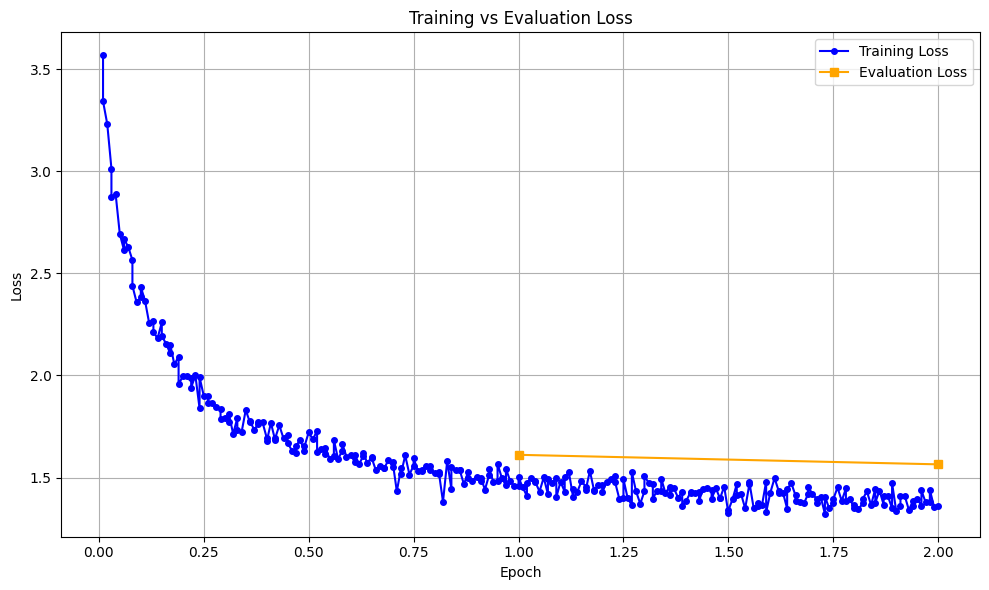

In [4]:
import ast
import matplotlib.pyplot as plt

# === Paths to your log files ===
train_log_file = "BitFit_training_logs.txt"       # Training loss logs (step-level)
eval_log_file = "BitFit_evaluation_logs.txt"            # Eval loss logs (epoch-level)

# === Read and parse training log ===
train_data = []
with open(train_log_file, 'r') as f:
    for line in f:
        if line.strip():
            log_entry = ast.literal_eval(line.strip())
            train_data.append(log_entry)

# Extract training epochs and losses
train_epochs = [entry['epoch'] for entry in train_data]
train_losses = [entry['loss'] for entry in train_data]

# === Read and parse evaluation log ===
eval_data = []
with open(eval_log_file, 'r') as f:
    for line in f:
        if line.strip():
            log_entry = ast.literal_eval(line.strip())
            eval_data.append(log_entry)

# Extract evaluation epochs and losses
eval_epochs = [entry['epoch'] for entry in eval_data]
eval_losses = [entry['eval_loss'] for entry in eval_data]

# === Plot both training and evaluation loss curves ===
plt.figure(figsize=(10, 6))

# Training loss: blue with small circles
plt.plot(train_epochs, train_losses, linestyle='-', marker='o', markersize=4, label='Training Loss', color='blue')

# Evaluation loss: orange with square markers
plt.plot(eval_epochs, eval_losses, linestyle='-', marker='s', markersize=6, label='Evaluation Loss', color='orange')

# Labels, title, legend, etc.
plt.title("Training vs Evaluation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
#----------------------------Load saved model from "bitfit_trained_model" directory and add it to base model to reload---------------------------
from transformers import WhisperForConditionalGeneration

loaded_model = WhisperForConditionalGeneration.from_pretrained("bitfit_trained_model_final").to('cuda')




In [ ]:
#-------------------------------Save the loaded model to hugging face------------------------
from transformers import WhisperForConditionalGeneration
from huggingface_hub import login

login(token="your_huggingface_token_here")  # paste your token here as a string

loaded_model.push_to_hub("imonghose/whisper-small-bengali-bitfit-final")



model.safetensors: 100%|██████████| 967M/967M [03:28<00:00, 4.63MB/s] 


CommitInfo(commit_url='https://huggingface.co/imonghose/whisper-small-bengali-bitfit-final/commit/9d8b5d72832213c6bbfe800e145252a5d49d8a05', commit_message='Upload WhisperForConditionalGeneration', commit_description='', oid='9d8b5d72832213c6bbfe800e145252a5d49d8a05', pr_url=None, repo_url=RepoUrl('https://huggingface.co/imonghose/whisper-small-bengali-bitfit-final', endpoint='https://huggingface.co', repo_type='model', repo_id='imonghose/whisper-small-bengali-bitfit-final'), pr_revision=None, pr_num=None)

In [50]:
#---------------------------------Reload the model from Hugging Face Hub-----------------------------------
final_loaded_model = WhisperForConditionalGeneration.from_pretrained("imonghose/whisper-small-bengali-bitfit-final").to('cuda')


d:\Germany\Documents\Magdeburg\Semester Documents\Sem 2\HC-NLP\Fine Tuning LLM(Bengali)\whisper-env\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ishmita\.cache\huggingface\hub\models--imonghose--whisper-small-bengali-bitfit-final. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


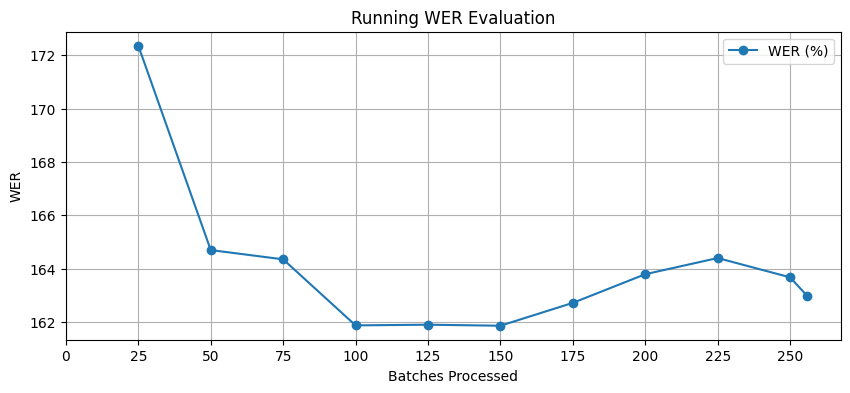

100%|██████████| 256/256 [1:19:07<00:00, 18.55s/it]


162.96148273967128

In [16]:
# Evaluate WER after the training
torch.cuda.empty_cache()
evaluation(loaded_model)

In [ ]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using trainer.model)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


In [21]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : সলাতাপাযন

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নাসেসেসেসেসে

 
-------9------
True : সে যুদ্ধকেই 
Pred : সাযেদে

 


In [52]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from hugging face)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : সলাতাপাযন

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নাসেসেসেসেসে

 
-------9------
True : সে যুদ্ধকেই 
Pred : সাযেদে

 


In [58]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from hugging face)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["test"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["test"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : সালাহউদ্দিনের জীবনী লেখার জন্য তিনি খ্যাত। 
Pred : সালেনিনিনিকানিনিনিনিনিনিনিনালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালালাল�

 
-------8------
True : এই কাগজ কালি ভাল শোষণ করার জন্য রঙ ভালভাবে ফুটে ওঠে। 
Pred : ইকিকিকিকিকিকাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযায

 
-------9------
True : অনেক ধনী দ্বীপটি কিনতে চেয়েছিলেন। 
Pred : ননিদনন দাতাতাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযাযায�

 
